# Introduction

A **pulsar** is a highly magnetized, rotating neutron star that emits beams of electromagnetic radiation from its magnetic poles. Neutron stars are the incredibly dense cores of massive stars that have gone supernova, and they are composed mostly of neutrons.

As the pulsar rotates, its magnetic poles emit powerful beams of radiation that sweep across space like a lighthouse beam. If the Earth happens to be in the path of these beams, we can detect them as regular pulses of radiation that arrive at regular intervals, hence the name "pulsar." However, these signals can often be confused with radio frequency interference (RFI) or noise, which can make it difficult to identify true pulsar signals. The purpose of this project is to develop a data science model that can differentiate between pulsar signals and RFI using statistical features.

> **How to determine if a signal is coming from a RFI or a pulsar?**

*Candidate* is the term that we'll use to refer to each detection. These are detected as periodic signals, which are represented by two curves: the **integrated profile** and the **DM-SNR curve**. The integrated profile is obtained by averaging the pulse signals emitted by the pulsar over a long observation period *(Lorimer and Kramer, 2005)*. Since the pulse profile of each pulsar is unique, the integrated profile represents the average of all the pulses emitted by the pulsar over a period of time. This allows astronomers to study the properties of pulsars, such as their rotation period, magnetic field strength, and emission properties.

However, the pulse signals detected by radio telescopes are affected by interstellar dispersion, where each pulse arrives at different times across different frequencies due to the scattering of radio waves by interstellar plasma. This dispersion can introduce uncertainty into the pulsar signal detection process. To account for this, a dispersion-measure-signal-to-noise **(DM-SNR) curve** is used *(Lyon, 2016)*. The **DM-SNR curve** represents the relationship between the dispersion measure (DM) and **signal-to-noise ratio (SNR)** of the detected pulse signals. The SNR is a measure of the strength of the pulsar signal relative to the background noise, and the DM is a measure of the amount of interstellar dispersion.

To further analyze and classify pulsar signals, each curve (the integrated profile and **DM-SNR curve**) is represented by four statistical variables: *mean, standard deviation, kurtosis, and skewness*. The mean is the average value of the curve, the standard deviation is the measure of the spread of the curve, the kurtosis is the measure of the peakedness of the curve, and the skewness is the measure of the symmetry of the curve. These statistical features can provide important information about the shape and distribution of the curves, which can be used to differentiate between pulsar signals and RFI.

In [1]:
#loading all the required libraries

library(tidyverse)
library(tidymodels)
library(repr)
library(httr)
library(readxl)
library(ggplot2)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

# Preliminary exploratory data analysis

### Loading the dataset into R

In [2]:
#downloading dataset from the url
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
GET(url, write_disk(pul <- tempfile(fileext = ".zip")))

#unzipping and loading the csv file in R
pulsar_data <- read_csv(unz(pul, "HTRU_2.csv"), col_names = FALSE)

#giving column names to the dataset
colnames(pulsar_data) <- c('mean_ip', 'std_ip', 'ekurtosis_ip', 'skew_ip', 'mean_dmsnr', 'std_dmsnr', 'ekurtosis_dmsnr', 'skew_dmsnr', 'class')

#mutating the class variable as a factor
pulsar_data <- mutate(pulsar_data, class = as.factor(class))
pulsar_data

Response [https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip]
  Date: 2023-03-10 01:13
  Status: 200
  Content-Type: application/x-httpd-php
  Size: 1.56 MB
<ON DISK>  /tmp/Rtmp1f7rvc/file11ed94d1b82.zipNULL

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_ip,std_ip,ekurtosis_ip,skew_ip,mean_dmsnr,std_dmsnr,ekurtosis_dmsnr,skew_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.234571412,-0.69964840,3.1998328,19.110426,7.975532,74.24222,0
102.50781,58.88243,0.465318154,-0.51508791,1.6772575,14.860146,10.576487,127.39358,0
103.01562,39.34165,0.323328365,1.05116443,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.068414638,-0.63623837,3.6429766,20.959280,6.896499,53.59366,0
88.72656,40.67223,0.600866079,1.12349169,1.1789298,11.468720,14.269573,252.56731,0
93.57031,46.69811,0.531904850,0.41672112,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.031460220,-0.11216757,0.9991639,9.279612,19.206230,479.75657,0
130.38281,39.84406,-0.158322759,0.38954045,1.2207358,14.378941,13.539456,198.23646,0
107.25000,52.62708,0.452688025,0.17034738,2.3319398,14.486853,9.001004,107.97251,0


The dataset we are using for this project is already in a tidy format.

In [3]:
#splitting the data for 78% training & 22% testing
#17,898 total samples;
#1,639 positive samples;
#16,259 negative samples;

pulsar_split <- initial_split(pulsar_data, prop = 0.78, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

glimpse(pulsar_train)
glimpse(pulsar_test)

Rows: 13,960
Columns: 9
$ mean_ip         <dbl> 140.56250, 102.50781, 103.01562, 136.75000, 88.72656, …
$ std_ip          <dbl> 55.68378, 58.88243, 39.34165, 57.17845, 40.67223, 46.6…
$ ekurtosis_ip    <dbl> -0.234571412, 0.465318154, 0.323328365, -0.068414638, …
$ skew_ip         <dbl> -0.69964840, -0.51508791, 1.05116443, -0.63623837, 1.1…
$ mean_dmsnr      <dbl> 3.1998328, 1.6772575, 3.1212375, 3.6429766, 1.1789298,…
$ std_dmsnr       <dbl> 19.110426, 14.860146, 21.744669, 20.959280, 11.468720,…
$ ekurtosis_dmsnr <dbl> 7.975532, 10.576487, 7.735822, 6.896499, 14.269573, 10…
$ skew_dmsnr      <dbl> 74.24222, 127.39358, 63.17191, 53.59366, 252.56731, 13…
$ class           <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
Rows: 3,938
Columns: 9
$ mean_ip         <dbl> 119.48438, 134.96094, 138.17969, 100.85156, 136.09375,…
$ std_ip          <dbl> 48.76506, 49.55433, 51.52448, 51.74352, 51.69100, 41.5…
$ ekurtosis_ip    <dbl> 0.03146022, -0.13530383, -0.03185233, 0.39383679,

## Summarization:

In [4]:
mean_pulsar_train <- pulsar_train |>
                     group_by(class) |> 
                     summarize(max_mean_ip = max(mean_ip, na.rm = TRUE),
                               max_std_ip = max(std_ip, na.rm = TRUE),
                               max_ekurtosis_ip = max(ekurtosis_ip, na.rm = TRUE),
                               max_skew_ip = max(skew_ip, na.rm = TRUE),
                               max_mean_dmsnr = max(mean_dmsnr, na.rm = TRUE),
                               max_std_dmsnr = max(std_dmsnr, na.rm = TRUE),
                               max_ekurtosis_dmsnr = max(ekurtosis_dmsnr, na.rm = TRUE),
                               max_skew_dmsnr = max(skew_dmsnr, na.rm = TRUE),
                               min_mean_ip = min(mean_ip, na.rm = TRUE),
                               min_std_ip = min(std_ip, na.rm = TRUE),
                               min_ekurtosis_ip = min(ekurtosis_ip, na.rm = TRUE),
                               min_skew_ip = min(skew_ip, na.rm = TRUE),
                               min_mean_dmsnr = min(mean_dmsnr, na.rm = TRUE),
                               min_std_dmsnr = min(std_dmsnr, na.rm = TRUE),
                               min_ekurtosis_dmsnr = min(ekurtosis_dmsnr, na.rm = TRUE),
                               min_skew_dmsnr = min(skew_dmsnr, na.rm = TRUE)) |>
                      pivot_longer(cols = -class,
                                  names_to = "max_min_variables",
                                  values_to = "Value") 

glimpse(mean_pulsar_train)
mean_pulsar_train

Rows: 32
Columns: 3
$ class             <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1…
$ max_min_variables <chr> "max_mean_ip", "max_std_ip", "max_ekurtosis_ip", "ma…
$ Value             <dbl> 190.4218750, 98.7789107, 4.7857859, 24.8724288, 223.…


class,max_min_variables,Value
<fct>,<chr>,<dbl>
0,max_mean_ip,190.42187500
0,max_std_ip,98.77891067
0,max_ekurtosis_ip,4.78578590
0,max_skew_ip,24.87242875
0,max_mean_dmsnr,223.39214050
0,max_std_dmsnr,110.64221060
0,max_ekurtosis_dmsnr,34.53984419
0,max_skew_dmsnr,1191.00083700
0,min_mean_ip,17.21093750


## Visualization:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



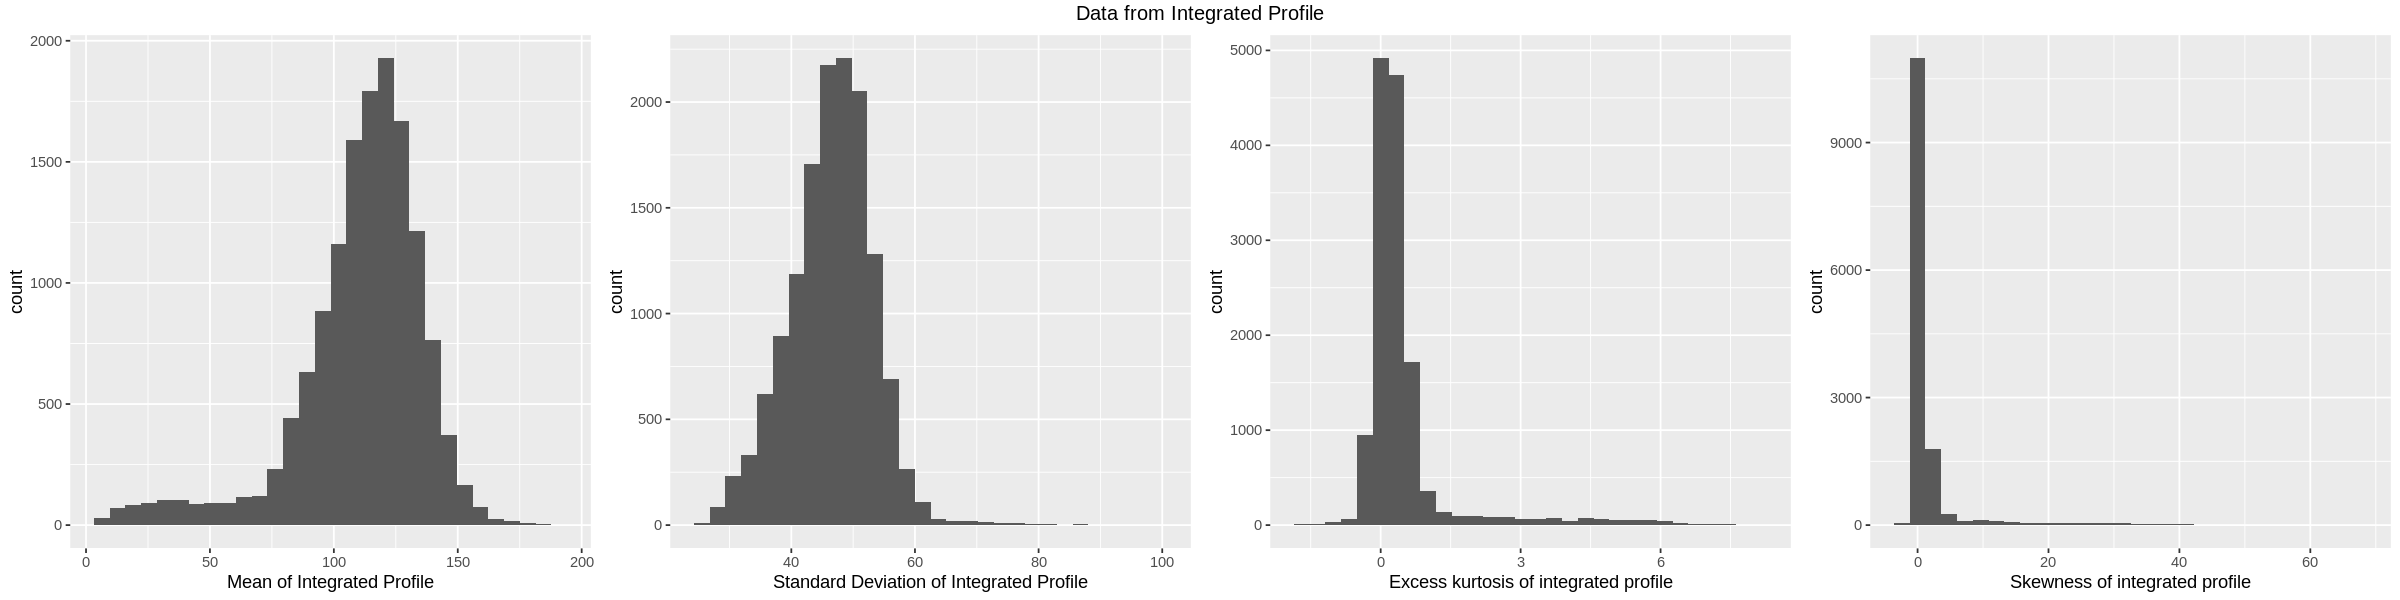

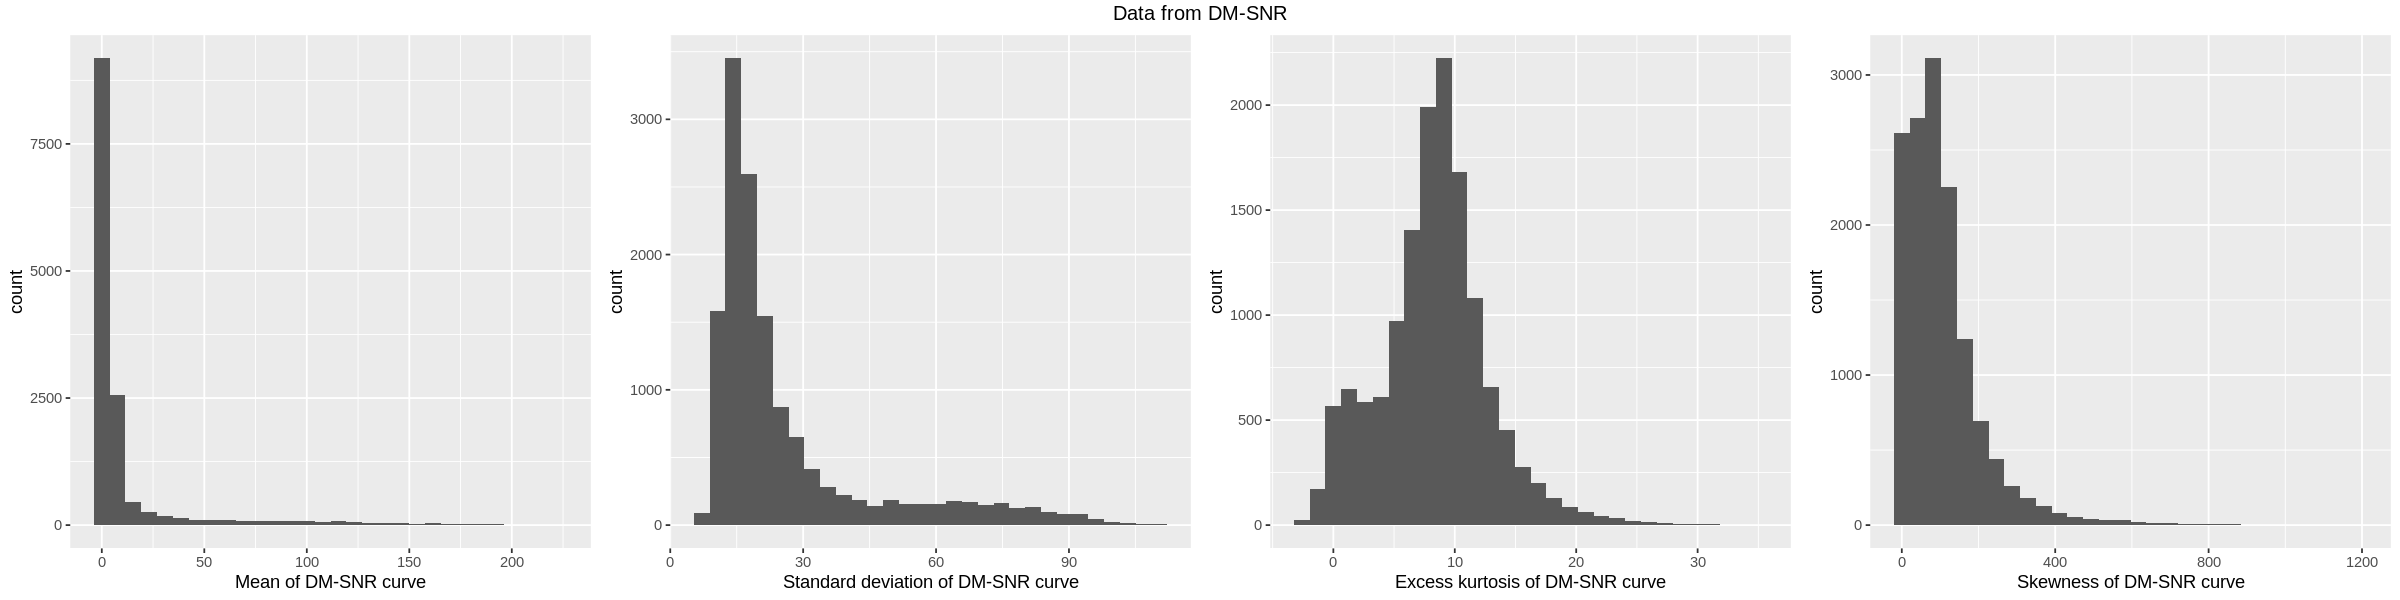

In [5]:
options(repr.plot.width=20, repr.plot.height=5)

hist_mean_ip <- ggplot(pulsar_train, aes(x = mean_ip)) +
                geom_histogram() + 
                labs(x = "Mean of Integrated Profile")

hist_std_ip <- ggplot(pulsar_train, aes(x = std_ip)) +
               geom_histogram() + 
               labs(x = "Standard Deviation of Integrated Profile")

hist_ekurtosis_ip <- ggplot(pulsar_train, aes(x = ekurtosis_ip)) +
                     geom_histogram() + 
                     labs(x = "Excess kurtosis of integrated profile")

hist_skew_ip <- ggplot(pulsar_train, aes(x = skew_ip)) +
                geom_histogram() + 
                labs(x = "Skewness of integrated profile")

hist_mean_dmsnr <- ggplot(pulsar_train, aes(x = mean_dmsnr)) +
                   geom_histogram() + 
                   labs(x = "Mean of DM-SNR curve")

hist_std_dmsnr <- ggplot(pulsar_train, aes(x = std_dmsnr)) +
                  geom_histogram() + 
                  labs(x = "Standard deviation of DM-SNR curve")

hist_ekurtosis_dmsnr <- ggplot(pulsar_train, aes(x = ekurtosis_dmsnr)) +
                        geom_histogram() + 
                        labs(x = "Excess kurtosis of DM-SNR curve")

hist_skew_dmsnr <- ggplot(pulsar_train, aes(x = skew_dmsnr)) +
                   geom_histogram() + 
                   labs(x = "Skewness of DM-SNR curve")

grid.arrange(hist_mean_ip, hist_std_ip, hist_ekurtosis_ip, hist_skew_ip, nrow = 1, top = "Data from Integrated Profile")
grid.arrange(hist_mean_dmsnr, hist_std_dmsnr, hist_ekurtosis_dmsnr, hist_skew_dmsnr, nrow = 1, top = 'Data from DM-SNR')
     

# Methods

We will use the **K-mean clustering algorithm** to work with the classification of pulsars from RFI and noise. We will split the data into a training set and a testing set using the initial split function in R. The proportions chosen will be *78%* and *22%* for the training and testing sets respectively. We are alloting a bigger chunk of data for training because we want the training model to be more accurate which will help make our classifier be more robust. Before feeding the data into the K-means clustering algorithm, we will **center and scale** the data to standardize the values to have a mean of 0 and a standard deviation of 1.

Next, we will select the most relevant features for the classification task. In this case, we will use the *mean, skewness, kurtosis, and standard deviation* from the **integrated profile** data points as these datasets focus on the intensity of the wave and the phase in which it is at. Therefore, the integrated profile would be more appropriate for determining if a star is pulsar because it takes into consideration the intensity of each of the signals.

After selecting the relevant features, we will implement the K-means clustering algorithm to cluster the data points into two groups, pulsars and non-pulsars. We will use the **Elbow method** to determine the optimal number of clusters. Further, we will train the K-means clustering algorithm on the training dataset and use the resulting clusters to label the training data as either pulsars or non-pulsars.

The next step is to test the K-means clustering algorithm on the testing dataset and use the resulting clusters to label the testing data as either pulsars or non-pulsars. The performance of the model will be evaluated using metrics such as *accuracy, precision, recall, and F1-score*. We will also optimize the K-means clustering algorithm by adjusting hyperparameters such as the number of clusters and the distance metric used.

To visualize the results, we will use a scatter plot to plot the class data predicted on the same plot as our model and the actual classes from the testing data, differentiating them by color. This visualization will enable us to observe the accuracy of the model.

Finally, we will analyze the results obtained from the K-means clustering algorithm and discuss its implications for identifying pulsars. We will highlight the strengths and limitations of the method and suggest ways to improve it in future studies. Overall, the proposed methodology involves **collecting the data**, **splitting it**, **preprocessing the data**, **selecting relevant features**, **implementing and optimizing the K-means clustering algorithm**, **testing the model**, **visualizing the results**, and **interpreting the results**.

# Expected outcomes and significance

The expected outcome of this study is to develop an effective K-means clustering algorithm that can accurately identify whether a star is a pulsar or not based on the integrated profile data points. In addition to the potential practical applications of the developed K-means clustering algorithm in astrophysics research, there are several other significances that this study may have such as:

- This study may contribute to the advancement in the field of machine learning by demonstrating the effectiveness of clustering algorithms in classification tasks. The proposed methodology may serve as a valuable reference for future studies involving clustering algorithms and feature selection.

- This study may lead to a better understanding of the properties and characteristics of pulsars by identifying the most relevant features that are indicative of a pulsar. We may gain insights into the underlying physics that governs the emission of electromagnetic radiation by these celestial objects.

- This study may contribute to the ongoing efforts to search for extraterrestrial life. Pulsars have been suggested as potential candidates for hosting habitable planets, and accurate identification of pulsars could facilitate the search for extraterrestrial life by providing better understanding of the environments surrounding these objects.